In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('image', origin='lower')
plt.rc('figure', figsize=(10, 6))
font = {'family' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

In [2]:
import pandas as pd
import numpy as np
import astropy.units as u

## Read in files and fix formatting

In [3]:
def file2df(file):
    with open(file, 'r') as ff:
        line = ff.readline()
        cols = line.strip('#').split()
    return pd.read_csv(file, comment='#', delim_whitespace=True, names=cols)


obs = file2df('../LSSTsimWDobs60.dat')
truth = file2df('../LSSTsimWDtruth60.dat')

obs.reset_index(inplace=True)
obs.columns = ['ra', 'dec', 'uObs', 'uErr', 'gObs', 'gErr', 'rObs', 'rErr', 'iObs', 'iErr', 'zObs', 'zErr', 'yObs', 'yErr', 'piObs', 'piErr', 'muRAObs', 'muDecObs', 'muErr']

In [4]:
obs.head()

,ra,dec,uObs,uErr,gObs,gErr,rObs,rErr,iObs,iErr,zObs,zErr,yObs,yErr,piObs,piErr,muRAObs,muDecObs,muErr
0,183.487,-1.36738,22.462,0.009,22.274,0.005,22.572,0.005,22.842,0.007,23.127,0.013,23.408,0.048,1.02,0.91,-1.60,-6.76,0.32
1,183.261,-1.25781,25.574,0.106,25.173,0.024,25.251,0.022,25.338,0.046,25.570,0.112,25.723,0.400,1.17,8.95,-3.19,-9.73,3.09
2,183.038,-1.32316,24.688,0.050,24.341,0.012,24.302,0.010,24.356,0.019,24.442,0.042,24.845,0.140,2.90,3.84,1.84,0.17,1.32
3,183.127,-1.13602,23.267,0.015,22.912,0.006,22.835,0.006,22.867,0.007,22.966,0.012,23.066,0.035,0.24,1.11,-12.58,3.17,0.38
4,183.339,-1.39733,23.504,0.018,23.093,0.006,22.963,0.006,22.957,0.007,23.034,0.012,23.088,0.036,-0.23,1.22,-8.69,-10.08,0.42


In [5]:
truth.head()

,ra,dec,u,g,r,i,z,y,Mr,logg,vR,vPhi,vZ,T,P
0,183.487,-1.36738,22.454,22.269,22.566,22.846,23.133,23.420,11.338,8.0,-50.89,-134.57,40.51,1,1
1,183.261,-1.25781,25.549,25.183,25.235,25.364,25.546,25.729,12.346,8.0,-51.56,-53.51,-3.59,1,1
2,183.038,-1.32316,24.718,24.354,24.301,24.356,24.471,24.587,12.867,8.0,-47.11,-170.19,94.17,1,1
3,183.127,-1.13602,23.288,22.913,22.834,22.871,22.972,23.073,12.989,8.0,29.71,-196.22,33.81,1,1
4,183.339,-1.39733,23.517,23.099,22.959,22.960,23.030,23.100,13.249,8.0,-4.74,-187.17,-37.27,1,1


# Problem A

## Define "Gold Sample" and Find Distance
Define a gold parallax sample" by requiring a signal-to-noise ratio of at least 10 for the trigonometric parallax measurement (i.e., piObs/piErr > 10). 

Compute the distance and distance modulus from the parallax measurement (D/kpc=1 milliarcsec/piObs) and compare it to the distance modulus determined from r and Mr listed in the \truth" file. 

In [6]:
# Calculate SNR and define a new dataframe with only gold sample WDs
obs['SNR'] = obs['piObs'] / obs['piErr']
gold_mask = np.abs(obs['SNR']) > 10
obs_gold = obs[gold_mask]

# Calculate the DM of these WDs
obs_gold['D(kpc)'] = 1 / obs_gold['piObs']
obs_gold['DM'] = 5 * np.log10(obs_gold['D(kpc)'] * 1000) - 5

# Calculate the truth DM values
truth['DM'] = truth['r'] - truth['Mr']

# Select the rows corresponding to the gold sample
truth_gold = truth[gold_mask]

<ipython-input-6-db5136659f55>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_gold['D(kpc)'] = 1 / obs_gold['piObs']
<ipython-input-6-db5136659f55>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_gold['DM'] = 5 * np.log10(obs_gold['D(kpc)'] * 1000) - 5


### Compare observed and truth distances

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


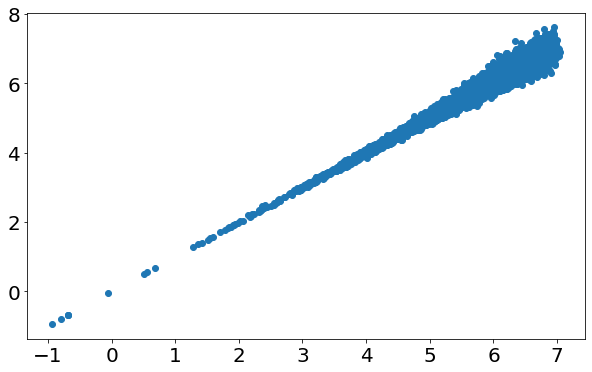

In [8]:
# Plot obs DM vs truth DM for gold sample
plt.scatter(obs_gold['DM'], truth_gold['DM'])


In [571]:
# spot check on # in gold sample:
len(obs_gold)

7156

## Examine distribution of distance modulus

Plot the distribution of the distance modulus difference and compute its median and root-mean-square scatter (hint: beware of outliers and clip at 3sig!). 
- Are they interestingly" small? Is the distribution deviating from a gaussian? 
- Would you expect it to? Why?

In [9]:
diffs_gold = obs_gold['DM'] - truth_gold['DM']

In [10]:
mean =diffs_gold.mean()
mean

In [11]:
med = diffs_gold.median()
med

-0.023409482528964354

In [12]:
rms = diffs_gold.std(ddof=0)
rms

0.1577687249231165

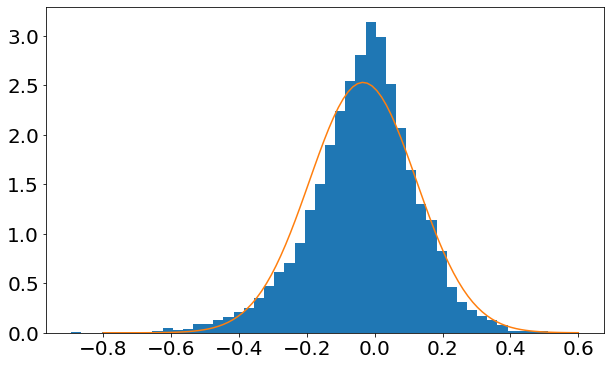

In [13]:
from scipy.stats import norm
plt.hist(diffs_gold, bins=50, density=True)
plt.plot(np.linspace(-.8, .6, 100), norm(mean, rms).pdf(np.linspace(-.8, .6, 100)))

### Calculate number of stars expected in full sample
How many white dwarfs would you expect in a \gold parallax sample" from the full LSST survey area of 20,000 deg2 (hint: simply scale by the area because the distance cutoff is smaller than the thin disk scaleheight)? 



Integrating the surface area of a sphere:
\begin{equation}
\int_{0}^{2\pi}\int_{\frac{5\pi}{6}}^{\pi} sin(b) db dl
\end{equation}
We get $2\pi(1-\frac{\sqrt{3}}{2}) \approx 0.8418 Sr$, or roughly $2763 deg^2$

In [14]:
# spot check with monte carlo
def run_mc(obs, n=100000, dec_bounds=None):
    if dec_bounds is None:
        bounds = {round(ra,1): obs.loc[(obs['ra'] < round(ra, 1) + .1) & (obs['ra'] > round(ra, 1)-.1), 'dec'].quantile([0,1]) for ra in np.linspace(158, 228, 701)}
        dec_bounds = pd.DataFrame(bounds).T.dropna()
        dec_bounds.columns = ['dec_min', 'dec_max']

    ra_min, ra_max = obs['ra'].quantile([0,1])
    dec_min, dec_max = obs['dec'].quantile([0,1])
    
    ras = np.random.choice(np.linspace(0, 359, 360), n)
    decs_weights = np.cos(np.linspace(-np.pi/2, np.pi/2, 91))/sum(np.cos(np.linspace(-np.pi/2, np.pi/2, 91)))
    decs = np.random.choice(np.linspace(-90, 90, 91),n,  p=decs_weights)
    
    mask = (ras > ra_min) & (ras < ra_max) & (decs > dec_min) & (decs < dec_max)
    num = 0
    for ra, dec in zi
    p(ras[mask], decs[mask]):
        # sub = obs.loc[(obs['ra'] < ra + 1) & (obs['ra'] > ra-1)]
        dec_min, dec_max = dec_bounds.loc[round(ra,1)]
        if (dec < dec_max) and (dec > dec_min):
            num+=1
    return num / n



# coords.append((decs, ras))

In [15]:
# monte carlo agrees prety well
run_mc(obs, n=1000000) * 41252

2758.438736

### Scale number of gold sample by area

In [16]:
20000/2763 * len(obs_gold)

51798.769453492576

We expect to see roughly 51800 white dwarfs in the full LSST sample meeting our gold standard of SNR > 10.

## Gold sample color color plot
Plot the (g-r) vs. (u-g) color-color diagram (using observed photometry) for this sample. Does it look crisper than the SDSS distribution 1https://ls.st/lop
2 shown in the bottom left corner of fig. 23 in Ivezic et al. (2007, AJ, 134, 973)?

Text(0.5, 1.0, 'Gold sample $g-r$ vs. $u-g$')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


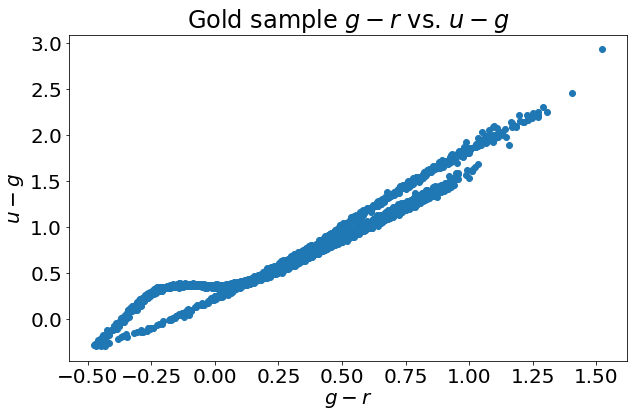

In [17]:
plt.scatter(obs_gold['gObs'] - obs_gold['rObs'], obs_gold['uObs'] - obs_gold['gObs'])
plt.xlabel(r'$g-r$')
plt.ylabel(r'$u-g$')
plt.title(r'Gold sample $g-r$ vs. $u-g$')

# Question B

## Estimate absolute magnitude from gObs-rObs
Using the “gold parallax sample” from A, estimate the absolute r band magnitude as Mobs = rObs − DMobs, with the observed distance modulus, DMobs, determined using the “measured” trigonometric parallax, piObs. Plot Mobs vs. (gObs−rObs) color for stars with T=1 (i.e., hydrogen white WDs; while this is a shortcut based on model input, it is possible to photometrically distinguish hydrogen from helium WDs by considering their four-dimensional color loci; however, this is beyond the scope of this project and hence this shortcut). 

### Select only hydrogen white dwarfs, plot g-r vs Mr

In [18]:
obs_gold['MrObs'] = obs_gold['rObs'] - obs_gold['DM']
hydrogen_WDs = obs_gold.loc[truth_gold['T'] == 1]

<ipython-input-18-ed6645b17f02>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_gold['MrObs'] = obs_gold['rObs'] - obs_gold['DM']


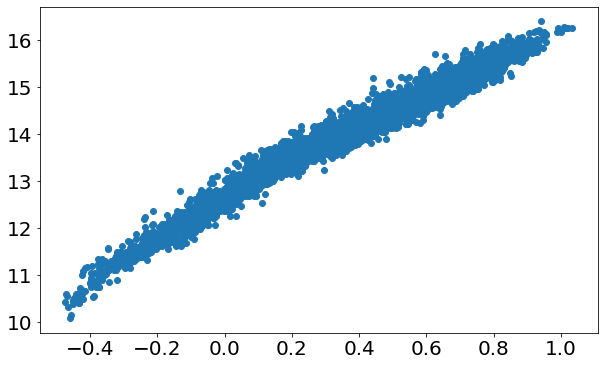

In [19]:
plt.scatter(hydrogen_WDs['gObs'] - hydrogen_WDs['rObs'], hydrogen_WDs['MrObs'])

### Fit function to binned g-r vs Mr

Fit a low-order polynomial to derive a photometric parallax relation, Mr(g−r) (hint: you may want to first compute the median Mr in about 0.1 mag wide bins of the g − r color, and then fit a polynomial to these median values vs. g −r bin value). How did you choose the order of your polynomial fit? In what range of Mr and (g − r) is your relation valid?

In [21]:
# Calculate g-r
hydrogen_WDs['g-r'] = hydrogen_WDs['gObs'] - hydrogen_WDs['rObs']


<ipython-input-21-c5e024769356>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hydrogen_WDs['g-r'] = hydrogen_WDs['gObs'] - hydrogen_WDs['rObs']


In [23]:
# Make bins of size ~.1 mag in g-r, find median Mr per bin

bins = np.arange(-.5, 1.1, .1)
bins = np.arange(hydrogen_WDs['g-r'].min(), hydrogen_WDs['g-r'].max(), .1)
# bins = np.array([-0.474, -0.37346667, -0.27293333, -0.1724, -0.07186667, 0.02866667, 0.1292, 0.22973333, 0.33026667, 0.4308, 0.53133333, 0.63186667, 0.7324, 0.83293333, 0.93346667, 1.034])
centers = (bins[1:] + bins[:-1]) / 2

hydrogen_WDs['bin'] = pd.cut(hydrogen_WDs['g-r'], bins, labels=centers).astype(float)
bin_meds = hydrogen_WDs.groupby('bin')['MrObs'].apply(np.median)

<ipython-input-23-fb5ad0899a6e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hydrogen_WDs['bin'] = pd.cut(hydrogen_WDs['g-r'], bins, labels=centers).astype(float)


Calculate summary statistics per bin

In [24]:
bin_meds = hydrogen_WDs.groupby('bin')['MrObs'].apply(np.median)
bin_stds = hydrogen_WDs.groupby('bin')['MrObs'].apply(np.std)  # not necessary
bin_counts = hydrogen_WDs.groupby('bin')['MrObs'].agg('count')  # not necessary

##### Optional
Use standard error of the mean as uncertainy in later calculation of reduced $\chi^2$

In [25]:
bin_sterr = bin_stds / np.sqrt(bin_counts)

### Fit polynomials from n=1 to n=4
Also calculate reduced-$\chi^2$

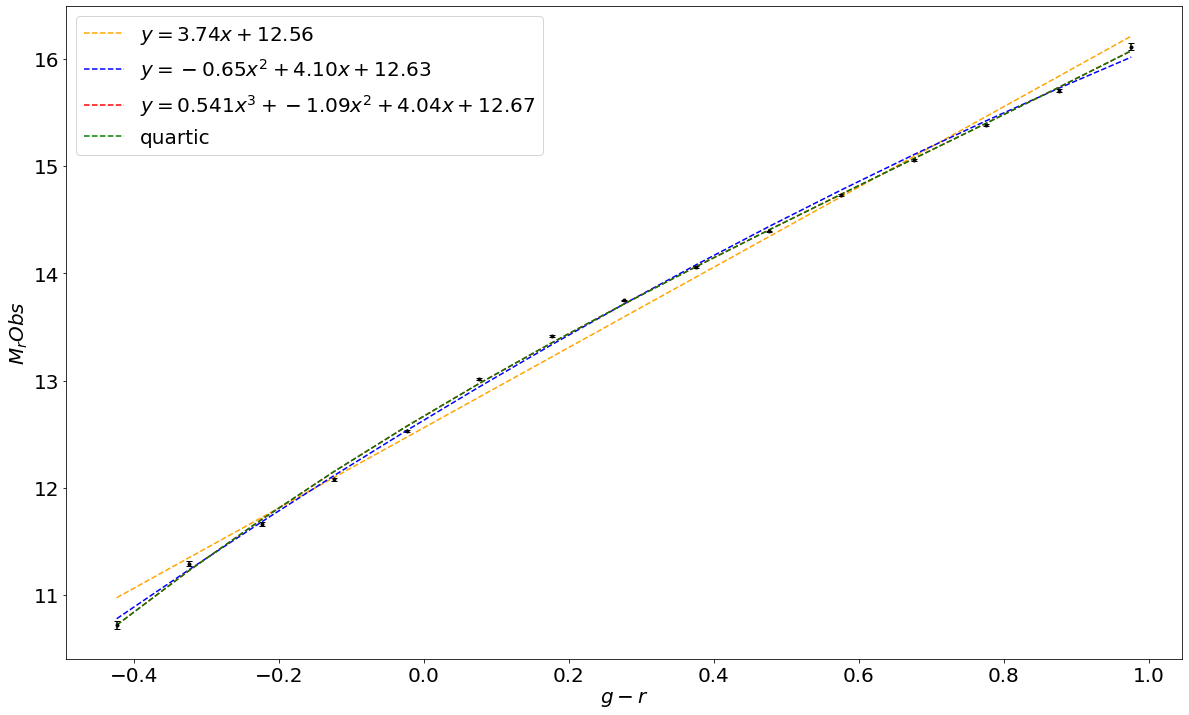

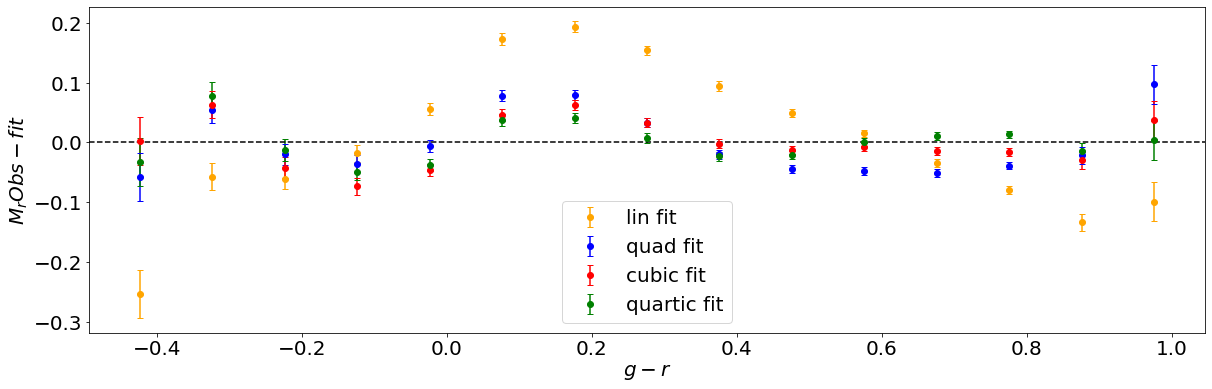

In [26]:
from scipy.optimize import curve_fit
from scipy.stats import chisquare

def lin(x, a, b):
    return a * x + b

def quad(x, a, b, c):
    return a * x ** 2 + b * x + c

def cubic(x, a, b, c, d):
    return a * x ** 3 + b * x ** 2 + c * x  + d

def quar(x, a, b, c, d, e):
    return a * x ** 4 + b * x ** 3 + c * x **2  + d * x + e

def red_chi_sq(obs, exp, err, dof):
    return sum((obs - exp) ** 2 / err ** 2) / (len(obs) - 1- dof)

popt_lin, pcov_lin = curve_fit(lin, bin_meds.index, bin_meds)
popt_quad, pcov_quad = curve_fit(quad, bin_meds.index, bin_meds)
popt_cubic, pcov_cubic = curve_fit(cubic, bin_meds.index, bin_meds)
popt_quar, pcov_quar = curve_fit(quar, bin_meds.index, bin_meds)

lin_chi2 = red_chi_sq(bin_meds, lin(bin_meds.index, *popt_lin), bin_sterr, 2)
quad_chi2 = red_chi_sq(bin_meds, quad(bin_meds.index, *popt_quad), bin_sterr, 3)
cubic_chi2 = red_chi_sq(bin_meds, cubic(bin_meds.index, *popt_cubic), bin_sterr, 4)
quar_chi2 = red_chi_sq(bin_meds, quar(bin_meds.index, *popt_quar), bin_sterr, 5)



### Plot fit and residuals

In [ ]:
plt.figure(figsize=(20,12))
plt.errorbar(bin_meds.index, bin_meds.values, yerr=bin_sterr, fmt='.', color='k', capsize=3, )
plt.plot(bin_meds.index, lin(bin_meds.index, *popt_lin), label=r'$y = {:.2f}x + {:.2f}$'.format(*popt_lin), color='orange', linestyle='--')
plt.plot(bin_meds.index, quad(bin_meds.index, *popt_quad), label=r'$y = {:.2f}x^2 + {:.2f}x + {:.2f}$'.format(*popt_quad), color='b', linestyle='--')
plt.plot(bin_meds.index, cubic(bin_meds.index, *popt_cubic), label=r'$y = {:.3f}x^3 + {:.2f}x^2 + {:.2f}x + {:.2f}$'.format(*popt_cubic), color='r', linestyle='--')
plt.plot(bin_meds.index, cubic(bin_meds.index, *popt_cubic), label='quartic', color='g', linestyle='--')
plt.legend()
plt.xlabel(r'$g-r$')
plt.ylabel(r'$M_rObs$')
plt.show()

def resid(exp, obs=bin_meds.values):
    return obs - exp

plt.figure(figsize=(20,6))
# plt.errorbar(bin_meds.index, bin_meds.values, yerr=bin_sterr.values, fmt='.', color='k', capsize=3, )
plt.errorbar(bin_meds.index, resid(lin(bin_meds.index, *popt_lin)), yerr=bin_sterr, label='lin fit', color='orange', capsize=3, fmt='o')
plt.errorbar(bin_meds.index, resid(quad(bin_meds.index, *popt_quad)), yerr=bin_sterr, label='quad fit', color='b', capsize=3, fmt='o')
plt.errorbar(bin_meds.index, resid(cubic(bin_meds.index, *popt_cubic)), yerr=bin_sterr, label='cubic fit', color='r', capsize=3, fmt='o')
plt.errorbar(bin_meds.index, resid(quar(bin_meds.index, *popt_quar)), yerr=bin_sterr, label='quartic fit', color='g', capsize=3, fmt='o')
plt.axhline(0, color='k', ls='--')
plt.legend()
plt.xlabel(r'$g-r$')
plt.ylabel(r'$M_rObs - fit$')
plt.show()

### Compare $\chi^2$

In [28]:
lin_chi2

150.21242094850916

In [29]:
quad_chi2

36.31947130284686

In [30]:
cubic_chi2

17.407909475752657

In [31]:
quar_chi2

11.686492476818918

### Get Mr bounds this fit is valid on

In [32]:
print(f"Valid from -.4  < g-r < to 1")
print(f"and from {cubic(-.4, *popt_cubic):.2f} < M_r <  {cubic(1, *popt_cubic):.2f}")

Valid from -.4  < g-r < to 1
and from 10.85 < M_r <  16.16


# Question C
Define a “gold proper motion sample” by requiring rObs < 24.5. What fraction of this sample has the observed proper motion measured witha signal-to-noise ratio (to compute SNR: add the two proper motion components in quadrature and divide by the listed proper motion error) of at least 3? 

In [33]:
obs.columns

Index(['ra', 'dec', 'uObs', 'uErr', 'gObs', 'gErr', 'rObs', 'rErr', 'iObs',
       'iErr', 'zObs', 'zErr', 'yObs', 'yErr', 'piObs', 'piErr', 'muRAObs',
       'muDecObs', 'muErr', 'SNR'],
      dtype='object')

### Define gold proper motion sample
Also look % with SNR > 3

In [329]:
ps_mask = obs['rObs'] < 24.5
ps_gold = obs[ps_mask]
ps_gold['mu'] = np.sqrt(ps_gold['muRAObs'] ** 2 + ps_gold['muDecObs'] ** 2)
print('Proportion of gold proper motion sample with SNR > 3: {:.3f}'.format((ps_gold['mu'] / ps_gold['muErr'] > 3).mean()))

Proportion of gold proper motion sample with SNR > 3: 0.975


<ipython-input-329-9aaf3f96b313>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ps_gold['mu'] = np.sqrt(ps_gold['muRAObs'] ** 2 + ps_gold['muDecObs'] ** 2)


drop SNR < 3

In [330]:
ps_gold = ps_gold.query('mu/muErr > 3')
ps_mask = [x in ps_gold.index for x in obs.index]

In [331]:
# Spot check number of values
sum(ps_mask)

178244

### Apply photometric relation from B to get Mr
Apply your photometric parallax relation from B to estimate Mr and distance (using Mr and rObs). Use this distance to compute tangential velocity, vtan (of course, you also need the observed proper motion; be careful about units!). 

In [355]:
ps_gold['g-r'] = ps_gold['gObs'] - ps_gold['rObs']

# backticks on query to treat quantity as string
# cut our sample to the range over which our Photometric relation holds
ps_gold = ps_gold.query("(`g-r` > -0.42) & (`g-r` < .98)")
ps_mask = [x in ps_gold.index for x in obs.index]

ps_gold['Phot_Mr'] = quar(ps_gold['g-r'], *popt_quar)
ps_gold['D(pc)'] = 10 ** ((ps_gold['rObs'] - ps_gold['Phot_Mr']) / 5 + 1)

<ipython-input-355-61d409b997f1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ps_gold['Phot_Mr'] = quar(ps_gold['g-r'], *popt_quar)
<ipython-input-355-61d409b997f1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ps_gold['D(pc)'] = 10 ** ((ps_gold['rObs'] - ps_gold['Phot_Mr']) / 5 + 1)


In [356]:
# spot check on ps_gold
ps_gold

,ra,dec,uObs,uErr,gObs,gErr,rObs,rErr,iObs,iErr,...,muRAObs,muDecObs,muErr,SNR,mu,g-r,Phot_Mr,D(pc),DM,vTan
0,183.487,-1.36738,22.462,0.009,22.274,0.005,22.572,0.005,22.842,0.007,...,-1.60,-6.76,0.32,1.120879,6.946769,-0.298,11.335388,1767.348933,11.236612,58.239047
3,183.127,-1.13602,23.267,0.015,22.912,0.006,22.835,0.006,22.867,0.007,...,-12.58,3.17,0.38,0.216216,12.973253,0.077,12.985650,932.975029,9.849350,57.415350
4,183.339,-1.39733,23.504,0.018,23.093,0.006,22.963,0.006,22.957,0.007,...,-8.69,-10.08,0.42,-0.188525,13.308738,0.130,13.196236,898.158025,9.766764,56.702045
5,183.624,-1.42716,24.233,0.031,23.762,0.008,23.599,0.007,23.588,0.010,...,-7.61,3.03,0.72,1.125604,8.191032,0.163,13.323885,1135.070922,10.275115,44.103261
11,183.776,-1.55913,25.296,0.084,24.697,0.016,24.364,0.011,24.274,0.018,...,-2.48,10.55,1.41,0.283619,10.837569,0.333,13.940513,1215.338802,10.423487,62.479614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905971,220.372,48.20000,24.935,0.066,24.602,0.015,24.404,0.011,24.421,0.020,...,-19.55,-14.13,1.47,0.164319,24.121762,0.198,13.456361,1547.133340,10.947639,177.029594
906097,216.576,51.05020,24.266,0.032,23.869,0.009,23.764,0.008,23.796,0.012,...,-30.51,14.66,0.83,1.531381,33.849309,0.105,13.097756,1359.092004,10.666244,218.226637
906138,216.191,51.30080,24.695,0.048,24.313,0.012,24.354,0.011,24.496,0.021,...,-5.09,-13.91,1.40,1.103448,14.812029,-0.041,12.493070,2356.058636,11.860930,165.542590
906143,216.052,51.50110,24.797,0.054,24.437,0.013,24.467,0.012,24.543,0.022,...,-10.91,-9.49,1.52,1.211845,14.459882,-0.030,12.540292,2428.519093,11.926708,166.577133


### Calculate DMs using Photometric Mr

<ipython-input-357-eafbb51ac754>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ps_gold['DM'] = ps_gold['rObs'] - ps_gold['Phot_Mr']


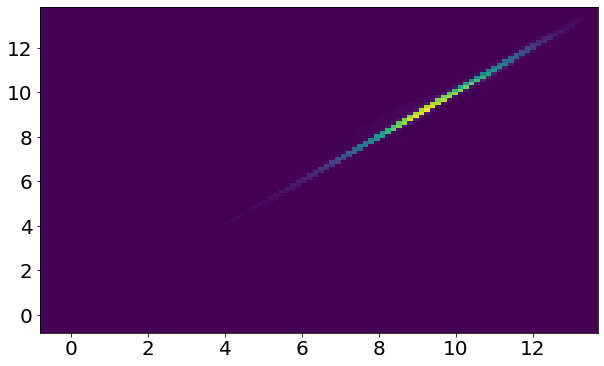

In [357]:
ps_gold['DM'] = ps_gold['rObs'] - ps_gold['Phot_Mr']

# Spot check with truth file
plt.hist2d(ps_gold['rObs'] - ps_gold['Phot_Mr'], truth.loc[ps_mask, 'DM'], bins=100)
plt.show()

## Look at different cutoffs for determining Disk v Halo stars by $v_{tan}$

Define a candidate disk sample as stars with vtan < vcutoff tan , and a candidate halo sample as stars with vtan > vcutoff tan . Using P from the truth file, plot the completeness and contamination for disk and halo samples as a function of v cutoff tan for 0 < vcutoff tan < 500 km/s (in steps of, say, 20 km/s). 

The completeness is defined as the number of (disk, halo) objects in the selected subsample divided by the total number of such objects, and contamination is the number of objects of the “wrong” type in the selected subsample divided by the total number in that subsample.

### Calculate $v_{tan}$

In [358]:
yr2s = 3.154e7
pc2km = 3.086e13
rad_p_s = (ps_gold['mu'] / 1000 / 3600) * (np.pi / 180) / yr2s
ps_gold['vTan'] =  rad_p_s * ps_gold['D(pc)'] * pc2km

<ipython-input-358-f6d328fb112e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ps_gold['vTan'] =  rad_p_s * ps_gold['D(pc)'] * pc2km


In [359]:
# spot check v_tan
ps_gold['vTan']

0          58.239047
3          57.415350
4          56.702045
5          44.103261
11         62.479614
             ...    
905971    177.029594
906097    218.226637
906138    165.542590
906143    166.577133
906157    172.582658
Name: vTan, Length: 175321, dtype: float64

### Calculate completeness and contamination

In [337]:
def get_comp_cont(sample_index, truth_df, seg):
    n_seg = sum(truth_df['P'] == seg)
    sample_len = len(sample_index)
    
    truth_values = truth_df.loc[sample_index, 'P']
    right = sum(truth_values == seg)
    wrong = sum(truth_values != seg)
    return right / n_seg, wrong / sample_len


disk_results = []
halo_results = []
for v_cutoff in np.linspace(20, 500, 25):
    disk_mask = ps_gold['vTan'] < v_cutoff
    halo_mask = ps_gold['vTan'] > v_cutoff
    
    disk_comp, disk_cont = get_comp_cont(ps_gold.loc[disk_mask].index, truth[ps_mask], 1)
    halo_comp, halo_cont = get_comp_cont(ps_gold.loc[halo_mask].index, truth[ps_mask], 2)
    disk_results.append((v_cutoff, disk_comp, disk_cont))
    halo_results.append((v_cutoff, halo_comp, halo_cont))


In [338]:
disk_df = pd.DataFrame(disk_results, columns=['vTan', 'completeness', 'contamination'])
halo_df = pd.DataFrame(halo_results, columns=['vTan', 'completeness', 'contamination'])
disk_df.set_index('vTan', inplace=True)
halo_df.set_index('vTan', inplace=True)

### Plot v_cutoff vs completeness, contamination for disk and halo
Note that there are many more disk objects than halo objects

<AxesSubplot:title={'center':'Halo'}, xlabel='vTan'>

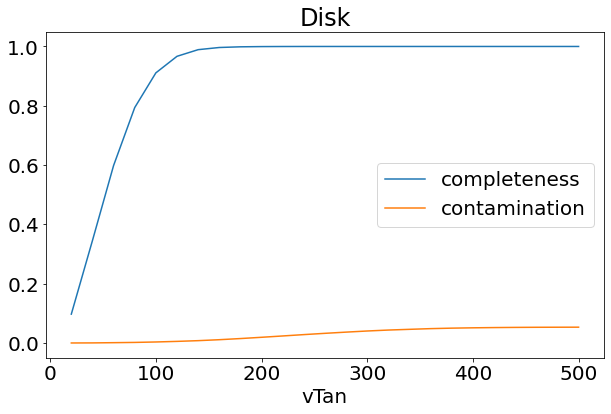

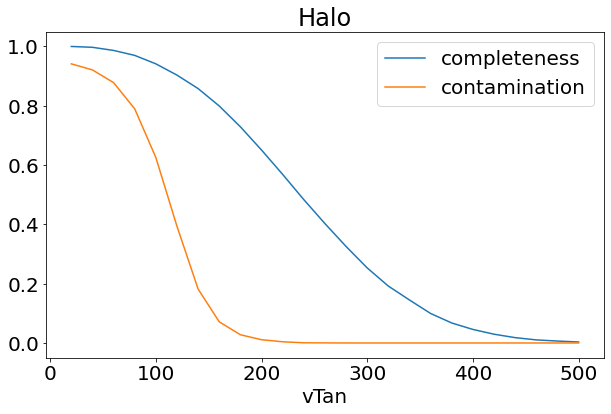

In [339]:
disk_df.plot(title='Disk')
halo_df.plot(title='Halo')

# Question D
Using the “gold proper motion sample” from C, define a candidate disk sample by vtan < 150 km/s, and a candidate halo sample by vtan > 200 km/s. Using your results from C, estimate the completeness and contamination for each subsample. 

## Find confusion matrix of our cutoffs

In [360]:
v_cutoff = 150 #km/s
disk_mask = ps_gold['vTan'] < v_cutoff
halo_mask = ps_gold['vTan'] > 200 

disk_comp, disk_cont = get_comp_cont(ps_gold.loc[disk_mask].index, truth[ps_mask], 1)
halo_comp, halo_cont = get_comp_cont(ps_gold.loc[halo_mask].index, truth[ps_mask], 2)

print(f'     | completeness | contamination \n' + '-'*35 + \
f'\ndisk |{disk_comp:13.3f} | {disk_cont:13.3f}\n' + '-'*35 + \
f'\nhalo |{halo_comp:13.3f} | {halo_cont:13.3f}')

     | completeness | contamination 
-----------------------------------
disk |        0.994 |         0.010
-----------------------------------
halo |        0.653 |         0.010


## Plot DM vs Mr to show our truncation at r_lim = 24

### Disk

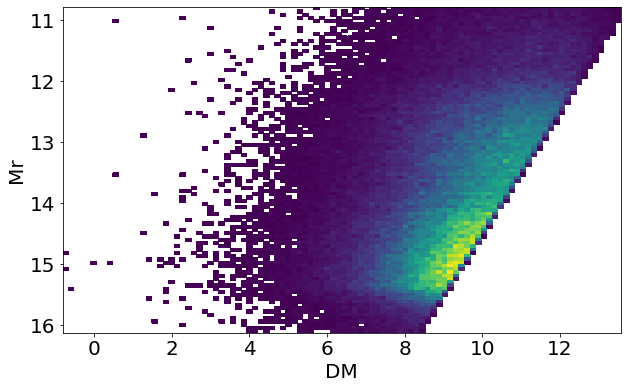

In [361]:
plt.hist2d(ps_gold.loc[disk_mask, 'DM'], ps_gold.loc[disk_mask, 'Phot_Mr'], bins=100, cmin=1)
plt.gca().invert_yaxis()
plt.xlabel('DM')
plt.ylabel('Mr')
plt.show()

### Halo

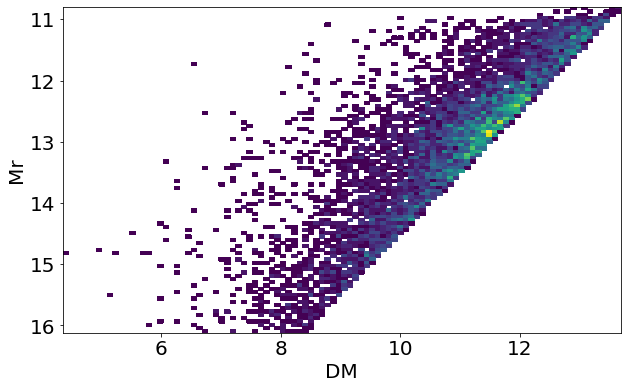

In [362]:
plt.hist2d(ps_gold.loc[halo_mask, 'DM'], ps_gold.loc[halo_mask, 'Phot_Mr'], bins=100, cmin=1)
plt.xlabel('DM')
plt.ylabel('Mr')
plt.gca().invert_yaxis()
plt.show()

## Uncorrected distribution of absolute magnitudes

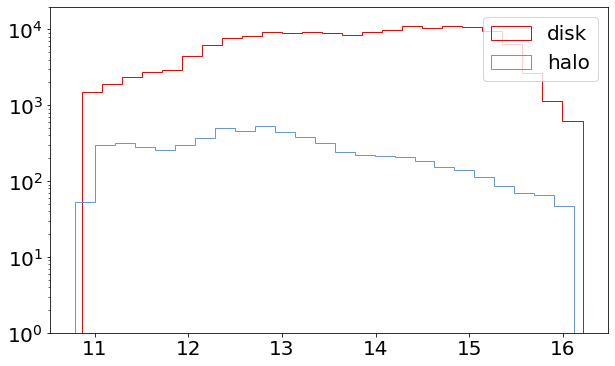

In [572]:
plt.hist(x=disk_data['Phot_Mr'], bins=25, color='r', histtype='step', label = 'disk')
plt.hist(x=halo_data['Phot_Mr'], bins=25, color='cornflowerblue', histtype='step', label = 'halo')
plt.yscale('log') 
plt.ylim([1, 20000])
plt.legend()

## Use Cminus method to recover true distributions of DM and Mr
We assume that DM is independent of Mr

Using the C method implemented in astroML2, compute the differential luminosity function for each subsample (this is the hardest part of this project!). Explain how did you get the normalization constant. 

In [344]:
from astroML.lumfunc import bootstrap_Cminus

In [345]:
r_lim = 24.5

# aux arrays
x_fit = np.linspace(0, 15, 42)
y_fit = np.linspace(10, 17, 42)


### For halo cut

# debugging weird behavior

In [371]:
halo_objects = pd.read_csv('../debugging.csv', delim_whitespace=True)

In [372]:
halo_objects
halo_objects.columns = ['DM', 'M_r', 'max_DM', 'max_Mr']
halo_objects.columns = ['DM', 'max_DM', 'M_r', 'max_Mr']
halo_objects = halo_objects[['DM', 'M_r', 'max_DM', 'max_Mr']]

In [368]:
share_cols = [x for x in halo_objects.index if x in halo_data.index]

In [260]:
truth

,ra,dec,u,g,r,i,z,y,Mr,logg,vR,vPhi,vZ,T,P,DM
0,183.487,-1.36738,22.454,22.269,22.566,22.846,23.133,23.420,11.338,8.0,-50.89,-134.57,40.51,1,1,11.228
1,183.261,-1.25781,25.549,25.183,25.235,25.364,25.546,25.729,12.346,8.0,-51.56,-53.51,-3.59,1,1,12.889
2,183.038,-1.32316,24.718,24.354,24.301,24.356,24.471,24.587,12.867,8.0,-47.11,-170.19,94.17,1,1,11.434
3,183.127,-1.13602,23.288,22.913,22.834,22.871,22.972,23.073,12.989,8.0,29.71,-196.22,33.81,1,1,9.845
4,183.339,-1.39733,23.517,23.099,22.959,22.960,23.030,23.100,13.249,8.0,-4.74,-187.17,-37.27,1,1,9.710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906212,213.948,52.60660,28.757,27.999,27.586,27.447,27.412,27.377,14.148,8.0,22.99,109.23,-68.96,1,2,13.438
906213,213.754,52.72680,28.255,27.437,26.981,26.819,26.768,26.716,14.291,8.0,-70.24,-181.66,-65.32,1,2,12.690
906214,214.194,52.52160,28.646,27.666,27.091,26.869,26.772,26.675,14.688,8.0,-154.37,-48.06,-1.92,1,2,12.403
906215,214.262,52.46750,28.967,27.827,27.141,26.856,26.714,26.571,15.077,8.0,-86.77,11.52,111.28,1,2,12.064


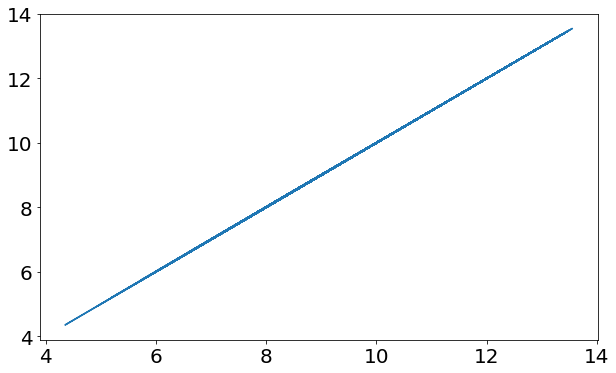

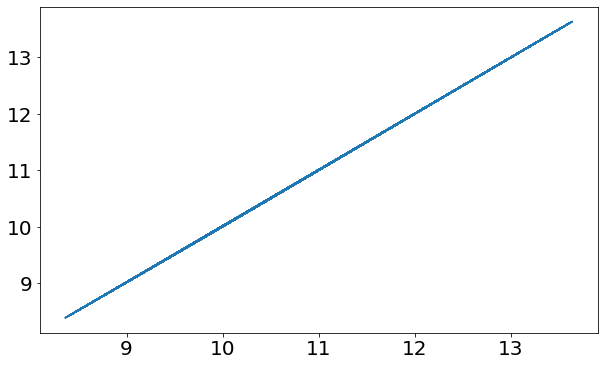

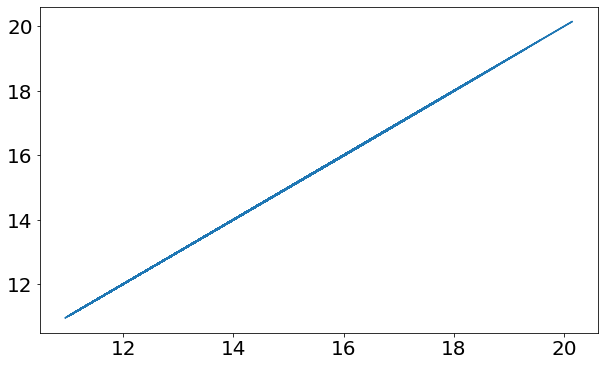

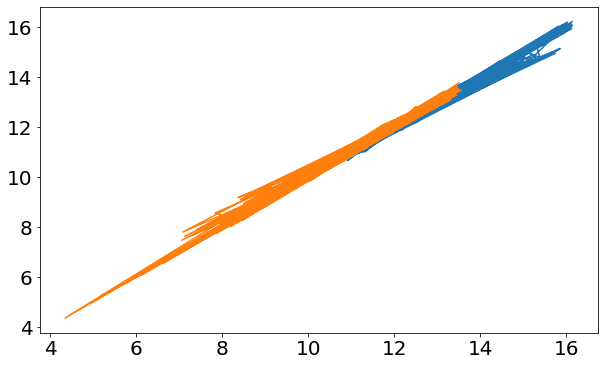

In [263]:
for col in ['DM', 'max_DM', 'max_Mr']:
    plt.plot(halo_objects.loc[share_cols,col], halo_data.loc[share_cols, col])
    plt.show()
plt.plot(halo_objects.loc[share_cols,'M_r'], truth.loc[share_cols, 'Mr'])
plt.plot(halo_objects.loc[share_cols,'DM'], truth.loc[share_cols, 'DM'])

In [276]:
share_cols

[363,
 823,
 15422,
 23739,
 36651,
 41332,
 59659,
 63594,
 72033,
 75499,
 85498,
 95154,
 97276,
 100135,
 100137,
 134537,
 134839,
 141686,
 144132,
 159716,
 164018,
 165650,
 166383,
 168947,
 181524,
 183323,
 186067,
 187409,
 191635,
 194116,
 195662,
 196985,
 201831,
 230759,
 232442,
 234556,
 236562,
 236711,
 242018,
 272885,
 277266,
 296218,
 316163,
 316405,
 319651,
 349400,
 353262,
 372434,
 376730,
 378530,
 396166,
 402533,
 433347,
 444108,
 514775,
 517682,
 517719,
 517858,
 517931,
 518034,
 518139,
 518141,
 518147,
 518171,
 518178,
 518275,
 518367,
 518465,
 518482,
 518523,
 518565,
 518639,
 518751,
 518764,
 518765,
 518805,
 518859,
 519115,
 519119,
 519125,
 519235,
 519236,
 519271,
 519384,
 519414,
 519451,
 519716,
 519740,
 519842,
 519848,
 519893,
 519936,
 519992,
 519996,
 520035,
 520175,
 520210,
 520284,
 520294,
 520523,
 520583,
 520590,
 520610,
 520750,
 520869,
 520875,
 520954,
 520972,
 520980,
 520996,
 521207,
 521357,
 521403,


In [289]:
y_fit

array([10.        , 10.17073171, 10.34146341, 10.51219512, 10.68292683,
       10.85365854, 11.02439024, 11.19512195, 11.36585366, 11.53658537,
       11.70731707, 11.87804878, 12.04878049, 12.2195122 , 12.3902439 ,
       12.56097561, 12.73170732, 12.90243902, 13.07317073, 13.24390244,
       13.41463415, 13.58536585, 13.75609756, 13.92682927, 14.09756098,
       14.26829268, 14.43902439, 14.6097561 , 14.7804878 , 14.95121951,
       15.12195122, 15.29268293, 15.46341463, 15.63414634, 15.80487805,
       15.97560976, 16.14634146, 16.31707317, 16.48780488, 16.65853659,
       16.82926829, 17.        ])

In [298]:
sam_only_rows = list(halo_objects[~halo_objects.index.isin(share_cols)].index)

In [309]:
halo_objects.drop(216660, inplace=True)

In [321]:
halo_objects[~halo_objects.index.isin([216660])]

,DM,M_r,max_DM,max_Mr
363,9.174685,14.952315,9.547685,15.325315
823,12.547563,11.433437,13.066563,11.952437
15422,11.160072,11.691928,12.808072,13.339928
23739,12.527618,11.897382,12.602618,11.972382
36651,12.356402,12.095598,12.404402,12.143598
...,...,...,...,...
905491,11.329291,12.373709,12.126291,13.170709
905563,7.278719,14.099281,10.400719,17.221281
905617,12.587371,11.075629,13.424371,11.912629
905808,9.256929,14.600071,9.899929,15.243071


In [369]:
halo_data[~halo_data.index.isin(share_cols)]

,DM,Phot_Mr,max_DM,max_Mr
636480,11.450327,12.561673,11.938327,13.049673
685189,11.941850,12.523150,11.976850,12.558150
870124,12.018114,12.155886,12.344114,12.481886


In [315]:
sam_only_rows = [144296, 216660, 263028, 389058, 396681, 402531, 499324]

In [305]:
sam_only_rows[-5:]

[263028, 389058, 396681, 402531, 499324]

In [380]:
halo_x = halo_objects['DM']
halo_y = halo_objects['M_r']
halo_xmax = halo_objects['max_DM']
halo_ymax = halo_objects['max_Mr']

xH, dxH, dyH, yH = bootstrap_Cminus(halo_x, halo_y, halo_xmax, halo_ymax, x_fit, y_fit, Nbootstraps=1, normalize=True)


In [382]:
yH

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan])

## Bug in Cminus?!?!?

In [384]:
from astroML.lumfunc import Cminus

In [479]:
# Set state of random generator if trying to reproduce. Skip this cell if first time.
np.random.set_state(test_state)

In [478]:
# Save state of the random seed before each run
test_state = np.random.get_state()

### run the following cell until we get a sample that breaks cminus

In [562]:
ind = np.random.randint(0, len(halo_x), len(halo_x))
test_x = halo_x.reset_index(drop=True)[ind]
test_y = halo_y.reset_index(drop=True)[ind]
test_xmax = halo_xmax.reset_index(drop=True)[ind]
test_ymax = halo_ymax.reset_index(drop=True)[ind]
xH, yH, cuml_xH, cuml_yH = Cminus(test_x, test_y, test_xmax, test_ymax)


> <ipython-input-559-fe795b7fa7ce>(43)testCminus()
     41     Ny[0] = np.inf
     42     pdb.set_trace()
---> 43     cuml_y = np.cumprod(1. + 1. / Ny)
     44     Ny[0] = 0
     45 

ipdb> c


In [ ]:
# save example that seems to break Cminus
pd.DataFrame({'xH':test_x, 'yH':test_y, 'xmaxH':test_xmax, 'ymaxH':test_ymax}).to_csv('../break_cminus.csv', index=False)

### use pdb to examine internal variables of Cminus

In [ ]:
test_data = pd.read_csv('../break_cminus.csv.gz')
x = test_data['xH']
y = test_data['yH']
xmax = test_data['xmaxH']
ymax = test_data['ymaxH']

xH, yH, cuml_xH, cuml_yH = testCminus(x, y, xmax, ymax)
print(cuml_yH) # nans

## Toy example

In [542]:
x1, y1, xmax1, ymax1 =map(np.array, ( [10.02, 10.00], [14.97, 14.99], [10.03, 10.01], [14.98, 15.00]))

In [543]:
Cminus(x1, y1, xmax1, ymax1)

(array([0., 0.]), array([0., 0.]), array([ 0., nan]), array([ 0., nan]))

### check that all constraints hold

In [544]:
x1 + ymax1

array([25., 25.])

In [545]:
y1 + xmax1

array([25., 25.])

In [546]:
x1 < xmax1

array([ True,  True])

In [547]:
y1 < ymax1

array([ True,  True])

### add python debugger to Cminus to examine variables while running 

In [559]:
import pdb
def testCminus(x, y, xmax, ymax):
    """Lynden-Bell's C-minus method

    Parameters
    ----------
    x : array_like
        array of x values
    y : array_like
        array of y values
    xmax : array_like
        array of maximum x values for each y value
    ymax : array_like
        array of maximum y values for each x value

    Returns
    -------
    Nx, Ny, cuml_x, cuml_y: ndarrays
        Nx and cuml_x are in the order of the sorted x array
        Ny and cuml_y are in the order of the sorted y array
    """
    # make copies of input
    x, y, xmax, ymax = map(np.array, (x, y, xmax, ymax))

    Nall = len(x)

    cuml_x = np.zeros(x.shape)
    cuml_y = np.zeros(y.shape)
    Nx = np.zeros(x.shape)
    Ny = np.zeros(y.shape)

    # first the y direction.
    i_sort = np.argsort(y)
    x = x[i_sort]
    y = y[i_sort]
    xmax = xmax[i_sort]
    ymax = ymax[i_sort]

    for j in range(1, Nall):
        Ny[j] = np.sum(x[:j] < xmax[j])
    Ny[0] = np.inf
    pdb.set_trace()
    cuml_y = np.cumprod(1. + 1. / Ny)
    Ny[0] = 0

    # renormalize
    cuml_y *= Nall / cuml_y[-1]

    #now the x direction
    i_sort = np.argsort(x)
    x = x[i_sort]
    y = y[i_sort]
    xmax = xmax[i_sort]
    ymax = ymax[i_sort]

    for i in range(1, Nall):
        Nx[i] = np.sum(y[:i] < ymax[i])
    Nx[0] = np.inf
    cuml_x = np.cumprod(1. + 1. / Nx)
    Nx[0] = 0

    # renormalize
    cuml_x *= Nall / cuml_x[-1]

    return Nx, Ny, cuml_x, cuml_y

In [271]:
ps_gold.columns

Index(['ra', 'dec', 'uObs', 'uErr', 'gObs', 'gErr', 'rObs', 'rErr', 'iObs',
       'iErr', 'zObs', 'zErr', 'yObs', 'yErr', 'piObs', 'piErr', 'muRAObs',
       'muDecObs', 'muErr', 'SNR', 'mu', 'g-r', 'Phot_Mr', 'D(pc)'],
      dtype='object')

### Resume calculations for the halo cut

In [366]:
halo_data = ps_gold.loc[halo_mask, ['DM', 'Phot_Mr']].copy()
halo_data['max_DM'] = r_lim - halo_data['Phot_Mr']
halo_data['max_Mr'] = r_lim - halo_data['DM']

halo_x = halo_data['DM']
halo_y = halo_data['Phot_Mr']
halo_xmax = halo_data['max_DM']
halo_ymax = halo_data['max_Mr']

xH_distr, xH_err, yH_distr, yH_err = bootstrap_Cminus(halo_x, halo_y, halo_xmax, halo_ymax, x_fit, y_fit, Nbootstraps=20, normalize=True)


In [246]:
# Spot check halo data
halo_data[['Phot_Mr', 'DM', 'max_DM', 'max_Mr']]

,Phot_Mr,DM,max_DM,max_Mr
363,14.948522,9.178478,9.551478,15.321522
823,11.432426,12.548574,13.067574,11.951426
15422,11.690151,11.161849,12.809849,13.338151
23739,11.895304,12.529696,12.604696,11.970304
36651,12.093449,12.358551,12.406551,12.141449
...,...,...,...,...
905491,12.371755,11.331245,12.128245,13.168755
905563,14.100019,7.277981,10.399981,17.222019
905617,11.076555,12.586445,13.423445,11.913555
905808,14.599066,9.257934,9.900934,15.242066


### For disk cut

In [74]:
disk_data = ps_gold.loc[disk_mask, ['DM', 'Phot_Mr']].copy()
disk_data['max_DM'] = r_lim - disk_data['Phot_Mr']
disk_data['max_Mr'] = r_lim - disk_data['DM']

disk_x = disk_data['DM']
disk_y = disk_data['Phot_Mr']
disk_xmax = disk_data['max_DM']
disk_ymax = disk_data['max_Mr']

xD_distr, xD_err, yD_distr, yD_err = bootstrap_Cminus(disk_x, disk_y, disk_xmax, disk_ymax, x_fit, y_fit, Nbootstraps=20, normalize=True)


## Plot unnormalized Mr distribution

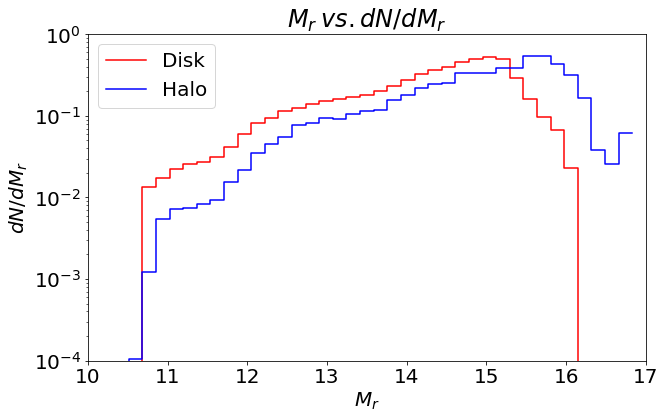

In [353]:
plt.step(y_fit[:-1], yD_distr, label='Disk', color='r')
plt.step(y_fit[:-1], yH_distr, label='Halo', color='b')
plt.yscale('log')
plt.xlim([10, 17])
plt.ylim([0.0001, 1])
plt.title(r'$M_r\:vs. dN/dM_r$')
plt.xlabel(r'$M_r$')
plt.ylabel(r'$ dN/dM_r$')
plt.legend()

### Plot number density as a function of distance

In [201]:
def dm_to_D(dm):
    return 10 ** ((dm / 5) + 1)

def get_vol_elements(bins, solid_angle, method='exact', disp=False):
    def puck_vol(distance, sa, thickness):
        return sa * distance ** 2 * thickness
    def cone_vol(distance, sa):
        return 1/3 * distance ** 3 * sa 
    
    lower_bound = bins[:-1]
    upper_bound = bins[1:]
    lower_bound = np.round(lower_bound, 6)
    upper_bound = np.round(upper_bound, 6)
    
    if method == 'avg':
        dVs =  0.5 * (puck_vol(lower_bound, solid_angle, upper_bound-lower_bound) + 
                      puck_vol(upper_bound, solid_angle, upper_bound-lower_bound))
        
    elif method == 'lower':
        dVs = puck_vol(lower_bound, solid_angle, upper_bound-lower_bound)
            
    elif method == 'upper':
        dVs = puck_vol(upper_bound, solid_angle, upper_bound-lower_bound)
        
    elif method == 'exact':
        dVs = cone_vol(upper_bound, solid_angle) - cone_vol(lower_bound, solid_angle)
    
    if disp:
        for ii in range(n):
            print(f'from {lower_bound[ii]} to {upper_bound[ii]}:\t {dVs[ii]}')
    
    return dVs

In [206]:
centers = (dm_to_D(x_fit[1:] )+ dm_to_D(x_fit[:-1])) / 2
thicknesses = dm_to_D(x_fit[1:] )- dm_to_D(x_fit[:-1])

vols = centers ** 2 * .8418 * thicknesses

### Plot unnormalized DM distribution

Text(0.5, 0, 'DM')

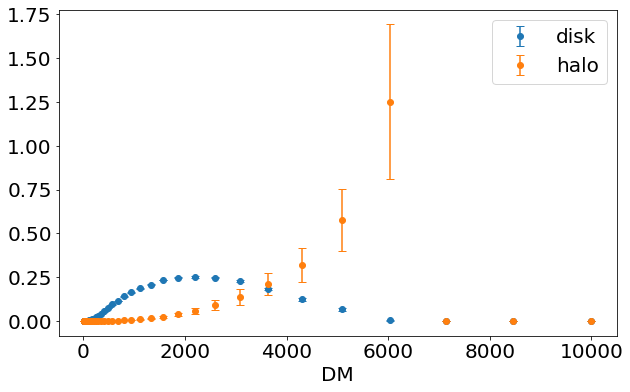

In [569]:
plt.errorbar(dm_to_D(x_fit[1:]), xD_distr, label='disk', yerr=xD_err, fmt='o', capsize=4)
plt.errorbar(dm_to_D(x_fit[1:]), xH_distr, label='halo', yerr=xH_err, fmt='o', capsize=4)
plt.legend()
plt.xlabel('DM')

## Plot densities as a function of distance

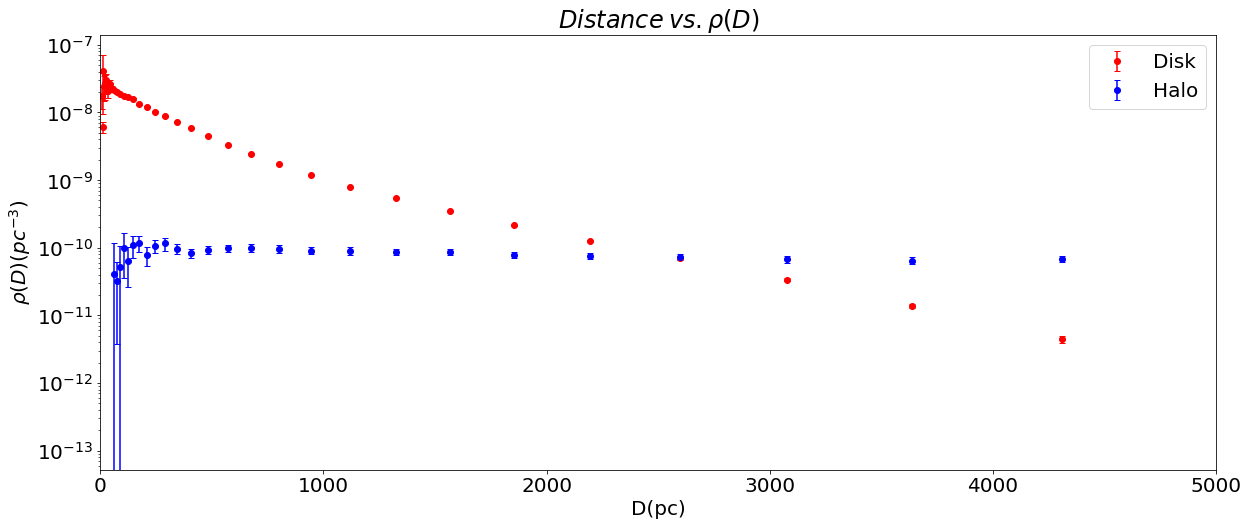

In [179]:
errorD = xD_err/get_vol_elements(dm_to_D(x_fit), 0.8418)
errorH = xH_err/get_vol_elements(dm_to_D(x_fit), 0.8418)

plt.figure(figsize=(20, 8))
plt.errorbar(dm_to_D(x_fit[:-1]), xD_distr/get_vol_elements(dm_to_D(x_fit), .8418), errorD, fmt='o', capsize=3, color='r', label='Disk')

plt.errorbar(dm_to_D(x_fit[:-1]), xH_distr/get_vol_elements(dm_to_D(x_fit), .8418), errorH, fmt='o', capsize=3, color='b', label='Halo')
plt.yscale('log')
plt.xlim([0, 5000])
plt.xlabel('D(pc)')
plt.ylabel(r'$\rho(D)(pc^{-3})$')
plt.title(r'$Distance\: vs. \rho(D)$')
plt.legend()
# plt.ylim([0.01, 1000])
plt.show()

Zeljko question

One thing I noticed is that in the uncorrected M_r distribution, the distributions extend out  to Mr~17. However, when we fitted the Mr(g-r) relation, we only fit it over points out to M~16.2--its it safe to extrapolate our function Mr(g-r) out to ranges we did not fit over? We currently are dropping the rows with g-r outside of our fitted range

In [190]:
halo_ymax.iloc[:50]

363       15.321522
823       11.951426
15422     13.338151
23739     11.970304
36651     12.141449
41332     12.482835
59659     11.735940
63594     11.261784
72033     11.691084
75499     11.069604
85498     11.536997
95154     11.979644
97276     11.403142
100135    11.213446
100137    11.861300
134537    11.030403
134839    11.349022
141686    12.128901
144132    11.883727
159716    10.950287
164018    11.745125
165650    11.381154
166383    11.866281
168947    11.345253
181524    11.903907
183323    11.114160
186067    11.512635
187409    10.994403
191635    12.600879
194116    11.103370
195662    11.974421
196985    11.747892
201831    11.137965
230759    11.469525
232442    11.044223
234556    12.373018
236562    11.443161
236711    12.037740
242018    11.636689
272885    11.279965
277266    11.489022
296218    11.565365
316163    12.080125
316405    11.343657
319651    14.376246
349400    11.566515
353262    11.847287
372434    12.450504
376730    13.343611
378530    11.774067


In [91]:
disk_xmax

0         13.164612
3         11.514350
4         11.303764
5         11.176115
11        10.559487
            ...    
904938    11.938327
905331    13.280215
905332    12.970700
905621    12.819015
905690    10.396631
Name: max_DM, Length: 166188, dtype: float64

# Old work

In [61]:


disk_data = ps_gold.loc[disk_mask, ['DM', 'Phot_Mr']].copy()
disk_data['max_DM'] = r_lim - disk_data['Phot_Mr']
disk_data['max_Mr'] = r_lim - disk_data['DM']

disk_x = disk_data['D(pc)']
disk_y = disk_data['Phot_Mr']
disk_xmax = disk_data['max_DM']
disk_ymax = disk_data['max_Phot_Mr']

xD_distr, xD_err, yD_distr, yD_err = bootstrap_Cminus(disk_x, disk_y, disk_xmax, disk_ymax, x_fit, y_fit, Nbootstraps=20, normalize=True)



halo_data = ps_gold.loc[halo_mask, ['DM', 'Phot_Mr']].copy()
halo_data['max_DM'] = r_lim - halo_data['Phot_Mr']
halo_data['max_Mr'] = r_lim - halo_data['DM']

halo_x = halo_data['D(pc)']
halo_y = halo_data['Phot_Mr']
halo_xmax = halo_data['max_DM']
halo_ymax = halo_data['max_Phot_Mr']

xH_distr, xH_err, yH_distr, yH_err = bootstrap_Cminus(halo_x, halo_y, halo_xmax, halo_ymax, x_fit, y_fit, Nbootstraps=20, normalize=True)

# disk_Nx, disk_Ny, disk_cuml_x, disk_cuml_y = Cminus(disk_x, disk_y, disk_xmax, disk_ymax)

halo = ps_gold.loc[halo_mask, ['D(pc)', 'Phot_Mr']].round({'D(pc)':-2, 'Phot_Mr':1})
halo_max_D = halo.groupby('Phot_Mr')['D(pc)'].apply(max)
halo_max_Mr = halo.groupby('D(pc)')['Phot_Mr'].apply(max)

halo_max_D.name = 'max D(pc)'
halo_max_Mr.name = 'max Phot_Mr'

halo_data = halo.merge(halo_max_D, left_on='Phot_Mr', right_index=True).merge(halo_max_Mr, left_on='D(pc)', right_index=True)

halo_x = halo_data['D(pc)']
halo_y = halo_data['Phot_Mr']
halo_xmax = halo_data['max_DM']
halo_ymax = halo_data['max_Mr']

halo_Nx, halo_Ny, halo_cuml_x, halo_cuml_y = Cminus(halo_x, halo_y, halo_xmax, halo_ymax)

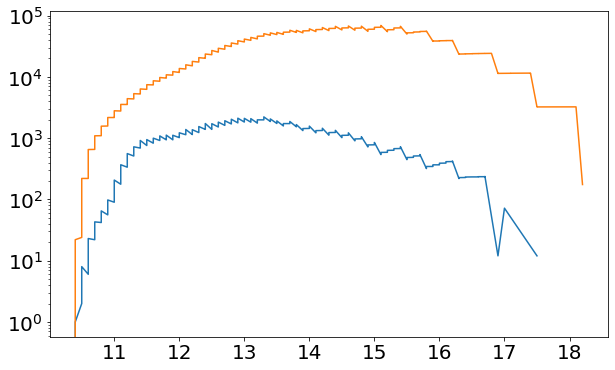

In [63]:
plt.semilogy(halo_y.sort_values(), halo_Ny)
plt.semilogy(disk_y.sort_values(), disk_Ny)

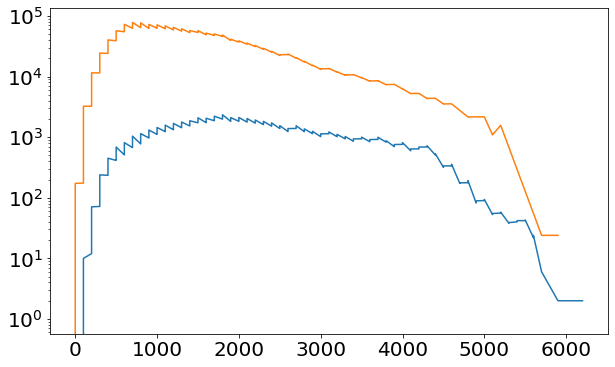

In [64]:
plt.semilogy(halo_x.sort_values(), halo_Nx)
plt.semilogy(disk_x.sort_values(), disk_Nx)

Plot your results in a log(Φ) vs. Mr diagram (with error bars!), and overplot the true luminosity function listed in files WDlumfuncDisk.dat and WDlumfuncHalo.dat (the differential LF listed in the second column is expressed as the number of stars per pc3 and mag; the LFs are slightly inconsistent with the Harris et al. due to a bug in simulations but, importantly, they do correspond to the “true” LFs for the simulated sample). 

Comment on (dis)agreement between your Φ and the true Φ (which was used to generate the simulated sample). IMPORTANT - YOU NEED TO FIX A BUG: Divide the halo Φ from file WDlumfuncHalo.dat by 200 to get a proper normalization in units of stars per pc3 and mag

In [ ]:
disk = ps_gold.loc[disk_mask, ['D(pc)', 'Phot_Mr']].round({'D(pc)':-2, 'Phot_Mr':1})
disk_max_D = disk.groupby('Phot_Mr')['D(pc)'].apply(max)
disk_max_Mr = disk.groupby('D(pc)')['Phot_Mr'].apply(max)

disk_max_D.name = 'max D(pc)'
disk_max_Mr.name = 'max Phot_Mr'

disk_data = disk.merge(disk_max_D, left_on='Phot_Mr', right_index=True).merge(disk_max_Mr, left_on='D(pc)', right_index=True)

disk_x = disk_data['D(pc)']
disk_y = disk_data['Phot_Mr']
disk_xmax = disk_data['max D(pc)']
disk_ymax = disk_data['max Phot_Mr']

disk_Nx, disk_Ny, disk_cuml_x, disk_cuml_y = Cminus(disk_x, disk_y, disk_xmax, disk_ymax)

halo = ps_gold.loc[halo_mask, ['D(pc)', 'Phot_Mr']].round({'D(pc)':-2, 'Phot_Mr':1})
halo_max_D = halo.groupby('Phot_Mr')['D(pc)'].apply(max)
halo_max_Mr = halo.groupby('D(pc)')['Phot_Mr'].apply(max)

halo_max_D.name = 'max D(pc)'
halo_max_Mr.name = 'max Phot_Mr'

halo_data = halo.merge(halo_max_D, left_on='Phot_Mr', right_index=True).merge(halo_max_Mr, left_on='D(pc)', right_index=True)

halo_x = halo_data['D(pc)']
halo_y = halo_data['Phot_Mr']
halo_xmax = halo_data['max D(pc)']
halo_ymax = halo_data['max Phot_Mr']

halo_Nx, halo_Ny, halo_cuml_x, halo_cuml_y = Cminus(halo_x, halo_y, halo_xmax, halo_ymax)

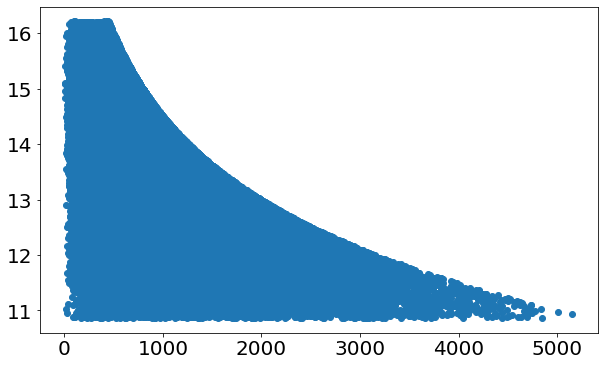

In [64]:
# (x, y) -> (DM, Phot_Mr)
plt.scatter(ps_gold.loc[disk_mask, 'D(pc)'], ps_gold.loc[disk_mask, 'Phot_Mr'])

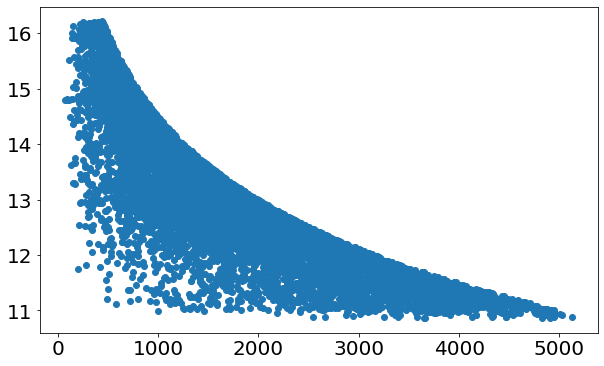

In [59]:
plt.scatter(ps_gold.loc[halo_mask, 'D(pc)'], ps_gold.loc[halo_mask, 'Phot_Mr'])

In [ ]:
def get_Dmax_from_M(r_lim, Mr):
    return 10 ** ((r_lim - Mr) / 5 + 1)

def get_Mmax_from_D(r_lim, D):
    return r_lim - 5 * np.log10(D / 10)